In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import albumentations as A
import albumentations.pytorch
import cv2
import sys
import random
import csv
import matplotlib.pyplot as plt
sys.path.append('../')
sys.path.append('../../data/')

from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import Sampler
import torch.optim as optim

from dataset import LbpDataset, train_transforms, val_transforms, test_transforms, get_indices, get_hard_label, collate_fn
from loss import LBPloss
from visualize import visualize

from tqdm import tqdm
# from resnet import resnet18, resnet12
from model import Darknet

In [2]:
import gc
torch.cuda.empty_cache()
gc.collect()

22

In [3]:
df = pd.read_csv('../../data/df.csv')
print(df.shape)

(3234, 11)


In [4]:
print(df.label.value_counts())

ASC-US                       1195
ASC-US with HPV infection     515
AS                            461
LSIL                          316
C                             290
LSIL with HPV infection        84
HS                             76
ASC-H                          70
HSIL                           68
LS                             50
Benign atypia                  46
AH                             36
Carcinoma                      18
판독불가                            4
Negative                        3
ASCUS-SIL                       2
Name: label, dtype: int64


In [5]:
df['label_id'] = df.label.apply(lambda x : 1.0 if ('ASC-US' in str(x) ) or ('AS' == str(x)) else 0.)
df = df[df['label_id'] == 1.]
df.shape

(2171, 12)

<AxesSubplot:>

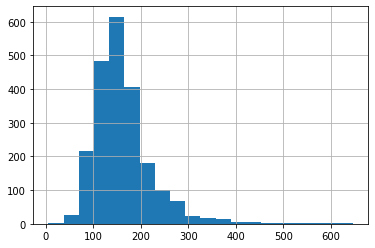

In [6]:
df.w.hist(bins=20)

In [7]:
df = df[(df['w'] < 200) & (df['w'] > 80)]
df.shape

(1689, 12)

In [8]:
df_data = df.groupby('file_name')
def get_data(img_id):
    if img_id not in df_data.groups:
        return dict(image_id=img_id, boxes=list())
    data  = df_data.get_group(img_id)
    boxes = data[['xmin', 'ymin', 'w', 'h', 'label_id']].values
    return dict(image_id = img_id, boxes = boxes)

train_list = [get_data(img_id) for img_id in df.file_name.unique()]
print(len(train_list))

train_list[0]

1398


{'image_id': 'patch_images/2021.01.06/LBC37-20210102(1)/LBC37-20210102(1)_1016.png',
 'boxes': array([[1.349e+03, 4.200e+02, 1.000e+02, 1.130e+02, 1.000e+00]])}

In [9]:
path = '/home/Dataset/scl/patch_images/2021.01.06/LBC24-20210102(1)/'
file_list = ['patch_images/2021.01.06/LBC24-20210102(1)/' + d for d in os.listdir(path)]
file_list[:2]


test_list = [get_data(img_id) for img_id in file_list]
test_list[:2]

[{'image_id': 'patch_images/2021.01.06/LBC24-20210102(1)/LBC24-20210102(1)_1160.png',
  'boxes': []},
 {'image_id': 'patch_images/2021.01.06/LBC24-20210102(1)/LBC24-20210102(1)_1817.png',
  'boxes': []}]

In [10]:
BATCH_SIZE = 2
STRIDE = 32
KERNEL_SIZE = 128
train_dataset = LbpDataset(
    train_list,
    transform=train_transforms,
    stride=STRIDE,
    kernel_size=KERNEL_SIZE
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=8,
#     pin_memory=config.PIN_MEMORY,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn
)

test_dataset = LbpDataset(
    test_list,
    transform=val_transforms,
    stride=STRIDE,
    kernel_size=KERNEL_SIZE    
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
#     pin_memory=config.PIN_MEMORY,
    shuffle=True,
    drop_last=False,
    collate_fn=collate_fn
)

In [11]:
images, cell_iou, targets, path, boxes = next(iter(train_loader))
# images = list(image for image in images)
images = np.stack(images)
cell_iou = torch.stack(cell_iou)
targets = torch.stack(targets)
iou, targets, multi_cell = get_hard_label(cell_iou, targets)


In [12]:
((cell_iou >= 0.5) & (cell_iou <= 1.0) ).sum()
((cell_iou > 0.) ).sum()
print((multi_cell == 1.).sum())
print((targets == 1.).sum())
print((multi_cell == 0.).sum())
print((cell_iou == 1.).sum())

tensor(4)
tensor(4)
tensor(199)
tensor(199)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


k_size 128 stride 32 grid size 64
(2048, 2048, 3)


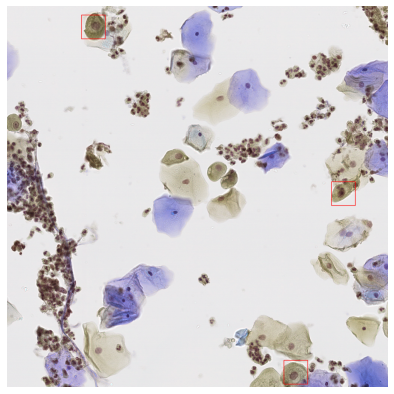

In [13]:
IMAGE_NUM = 1
STRIDE = 32
KERNEL_SIZE = STRIDE * 4
kernel_size = KERNEL_SIZE
stride = STRIDE
# grid_size = 1 + int((images[IMAGE_NUM].shape[1]- kernel_size) / stride )
grid_size = 64
print('k_size {} stride {} grid size {}'.format(kernel_size, stride, grid_size))
# row, col = torch.where((cell_iou[IMAGE_NUM].view(grid_size,grid_size) > 0.0) & \
#                        (cell_iou[IMAGE_NUM].view(grid_size,grid_size) <= 0.3))
row, col = torch.where((multi_cell[IMAGE_NUM].view(grid_size,grid_size) == 1.))
bboxes = []

for x, y in zip(col, row) :
#     print(int(x), int(y))
    xmin = int(x) * stride - (kernel_size-stride)/2
    xmax = xmin + kernel_size
    ymin = int(y) * stride - (kernel_size-stride)/2
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
# print(len(bboxes))

# visualize(images[IMAGE_NUM].permute(2,1,0).cpu().detach().numpy(), bboxes)
visualize(images[IMAGE_NUM], bboxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


k_size 128 stride 32 grid size 64
[[400.0, 48.0, 528.0, 176.0], [1744.0, 944.0, 1872.0, 1072.0], [1488.0, 1904.0, 1616.0, 2032.0], [410.0, 29.0, 536.0, 179.0], [1468.0, 1900.0, 1613.0, 2037.0], [1733.0, 934.0, 1864.0, 1058.0]]
(2048, 2048, 3)


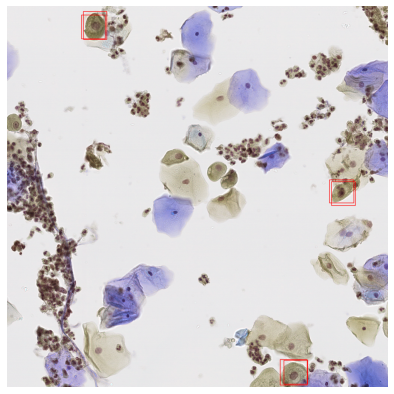

In [14]:
IMAGE_NUM = 1
STRIDE = 32
KERNEL_SIZE = STRIDE * 4
kernel_size = KERNEL_SIZE
stride = STRIDE
# grid_size = 1 + int((images[IMAGE_NUM].shape[1]- kernel_size) / stride )
grid_size = 64
print('k_size {} stride {} grid size {}'.format(kernel_size, stride, grid_size))
row, col = torch.where(targets.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM] == 1.)
bboxes = []
org_boxes = np.array(boxes[IMAGE_NUM])

kernel_size = KERNEL_SIZE
stride = STRIDE
for x, y in zip(col, row) :
    xmin = int(x) * stride - (kernel_size-stride)/2
    xmax = xmin + kernel_size
    ymin = int(y) * stride - (kernel_size-stride)/2
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
    
for box in boxes[IMAGE_NUM] :
    xmin, ymin, w, h, _ = box
    bboxes.append([xmin, ymin, xmin+w, ymin+h])
print((bboxes))
visualize(images[IMAGE_NUM], bboxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2048, 2048, 3)


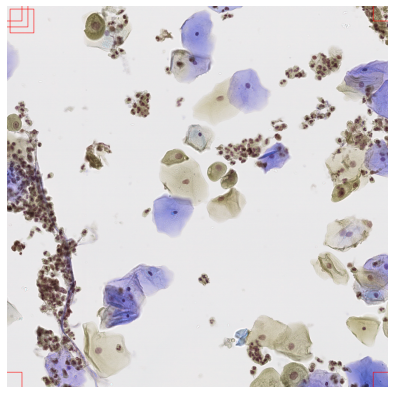

In [15]:
bboxes = []
for x, y in zip([0, 63, 0, 63, 1,2], [0,63, 63, 0, 1,2]) :
    xmin = int(x) * stride - (kernel_size-stride)/2
    xmax = xmin + kernel_size
    ymin = int(y) * stride - (kernel_size-stride)/2
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
visualize(images[IMAGE_NUM], bboxes)    

<class 'numpy.ndarray'>
[[2.900e+01 1.512e+03 1.500e+02 1.260e+02 1.000e+00]
 [1.900e+03 4.350e+02 1.370e+02 1.450e+02 1.000e+00]
 [9.340e+02 1.840e+02 1.240e+02 1.310e+02 1.000e+00]]
(2048, 2048, 3)


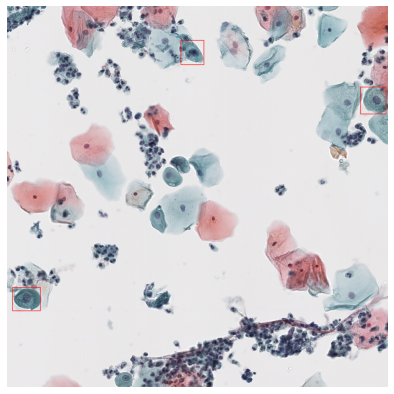

In [16]:
img_path = path[IMAGE_NUM]
abs_path = '/home/Dataset/scl/'

train_image = cv2.imread(abs_path + img_path)
print(type(train_image))
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
boxes = get_data(img_path)['boxes']
print(boxes)
boxes[:,2] = boxes[:,0] + boxes[:,2]
boxes[:,3] = boxes[:,1] + boxes[:,3]

visualize(train_image, boxes[:,:4])

In [17]:
device = torch.device('cuda')
model = Darknet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4 )
loss_fn = LBPloss(device).to(device)
scaler = torch.cuda.amp.GradScaler()

In [18]:
epochs = 15
init_loss = 1.
saved_model = '../trained_models/darknet/model.pt'
model.load_state_dict(torch.load(saved_model))
for epoch in (range(epochs)) :
    batch_losses = []
    loop = tqdm(train_loader, leave=True)
    model.train()
    for images, iou, targets, path, box in loop :
        images = torch.from_numpy(np.stack(images))
        iou = torch.stack(iou)
        targets = torch.stack(targets)        
        batch_size, grid_len, _ = iou.shape
        images = images.permute(0,3,1,2).to(device)

#         indices, iou, targets = get_indices(iou, targets)
        iou, targets, multi_cell = get_hard_label(iou, targets)
        labels = torch.cat([iou, targets, multi_cell], dim=-1)
        labels = labels.to(device)
        
        cell_out, ab_out, multi_out = model(images, indices=None)
        cell_out = cell_out.permute(0,2,3,1).view(batch_size, grid_len, -1)
        ab_out = ab_out.permute(0,2,3,1).view(batch_size, grid_len, -1)
        multi_out = multi_out.permute(0,2,3,1).view(batch_size, grid_len, -1)
        loss, cell_loss, ab_loss, multi_loss = loss_fn(cell_out, ab_out, multi_out, labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        batch_losses.append(loss.item())
        mean_loss = sum(batch_losses) / len(batch_losses)
        loop.set_postfix(total_loss=mean_loss, cell_loss=cell_loss.item(), 
                         multi_loss = multi_loss.item(), ab_loss=ab_loss.item()) 

    if mean_loss < init_loss :
        init_loss = mean_loss
        torch.save(model.state_dict(), saved_model)
        print('model is saved')


  0%|          | 0/699 [00:00<?, ?it/s]

model is saved


  0%|          | 0/699 [00:00<?, ?it/s]

model is saved


  0%|          | 0/699 [00:00<?, ?it/s]

model is saved


  0%|          | 0/699 [00:00<?, ?it/s]

model is saved


  0%|          | 0/699 [00:00<?, ?it/s]

model is saved


  0%|          | 0/699 [00:00<?, ?it/s]

model is saved


  0%|          | 0/699 [00:00<?, ?it/s]

model is saved


  0%|          | 0/699 [00:00<?, ?it/s]

model is saved


  0%|          | 0/699 [00:00<?, ?it/s]

model is saved


100%|██████████| 699/699 [18:03<00:00,  1.55s/it, ab_loss=0.0144, cell_loss=9.19e-5, multi_loss=0.0152, total_loss=0.0597]    


In [19]:
saved_model = '../trained_models/darknet/model_v1.pt'
torch.save(model.state_dict(), saved_model)
# saved_model = '../trained_models/model_v1.pt'

In [20]:
saved_model = '../trained_models/darknet/model.pt'
device = torch.device('cpu')
model = Darknet().to(device)
model.load_state_dict(torch.load(saved_model))
model.eval()

Darknet(
  (layers): ModuleList(
    (0): CNNBlock(
      (conv): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky): LeakyReLU(negative_slope=0.1)
    )
    (1): CNNBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky): LeakyReLU(negative_slope=0.1)
    )
    (2): ResidualBlock(
      (layers): ModuleList(
        (0): Sequential(
          (0): CNNBlock(
            (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (leaky): LeakyReLU(negative_slope=0.1)
          )
          (1): CNNBlock(
            (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

In [67]:

images, cell_iou, targets , path, box = next(iter(train_loader))
# images, cell_iou, targets , path = next(iter(test_loader))
images = torch.from_numpy(np.stack(images))
cell_iou = torch.stack(cell_iou)
targets = torch.stack(targets)
print(images.shape)
# print(cell_iou.shape)
batch_size, seq_len, _ = cell_iou.shape
images = images.permute(0,3,1,2).to(device)
iou, targets, multi_cell = get_hard_label(cell_iou, targets)
with torch.no_grad():
    cell_out, ab_out, multi_out = model(images, indices=None)
print(cell_out.shape)    

torch.Size([2, 2048, 2048, 3])
torch.Size([2, 1, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


***************** tensor(0.7355)
3
(2048, 2048, 3)


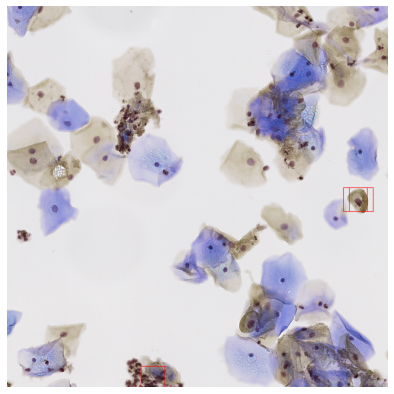

In [72]:
# image with prediction
IMAGE_NUM=0
outputs = multi_out
# maxi = torch.max(torch.sigmoid(outputs.permute(0,2,3,1)[IMAGE_NUM,:,:,0])).cpu()
maxi = torch.max((outputs.permute(0,2,3,1)[IMAGE_NUM,:,:,0])).cpu()
print('*****************', maxi)
row, col = ((outputs.permute(0,2,3,1)[IMAGE_NUM,:,:,0]) > 0.5).cpu().detach().nonzero(as_tuple=True)
bboxes = []

# for x, y in zip(row, col) :
for x, y in zip(col, row) :
    xmin = int(x) * stride - (kernel_size-stride)/2
    xmax = xmin + kernel_size
    ymin = int(y) * stride - (kernel_size-stride)/2
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
print(len(bboxes))
visualize(images[IMAGE_NUM].permute(1,2,0).cpu().detach().numpy(), bboxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.8413)
6
(2048, 2048, 3)


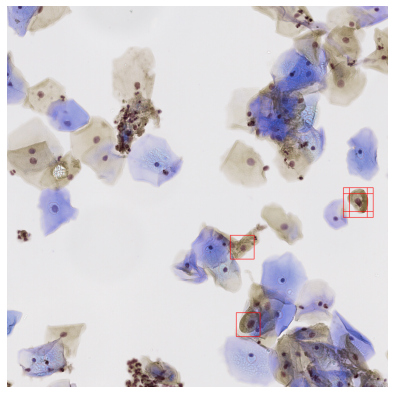

In [73]:
outputs = ab_out
# maxi = torch.max(torch.sigmoid(outputs.permute(0,2,3,1)[IMAGE_NUM,:,:,0])).cpu()
maxi = torch.max((outputs.permute(0,2,3,1)[IMAGE_NUM,:,:,0])).cpu()
print(maxi)
row, col = ((outputs.permute(0,2,3,1)[IMAGE_NUM,:,:,0]) > 0.6).cpu().detach().nonzero(as_tuple=True)
bboxes = []

# for x, y in zip(row, col) :
for x, y in zip(col, row) :
    xmin = int(x) * stride - (kernel_size-stride)/2
    xmax = xmin + kernel_size
    ymin = int(y) * stride - (kernel_size-stride)/2
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
print(len(bboxes))
visualize(images[IMAGE_NUM].permute(1,2,0).cpu().detach().numpy(), bboxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 2048, 2048])
2
(2048, 2048, 3)


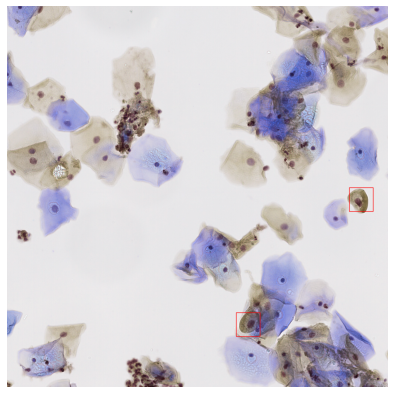

In [74]:
grid_size = 64
row, col = torch.where(targets.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM] == 1.)
bboxes = []

kernel_size = KERNEL_SIZE
stride = STRIDE
print(images.shape)
for x, y in zip(col, row) :
    xmin = int(x) * stride - (kernel_size-stride)/2
    xmax = xmin + kernel_size
    ymin = int(y) * stride - (kernel_size-stride)/2
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
print(len(bboxes))
visualize(images[IMAGE_NUM].permute(1,2,0).cpu().detach().numpy(), bboxes)

[[ 97. 926. 124. 139.   1.]
 [667. 279. 139. 145.   1.]]
(2048, 2048, 3)


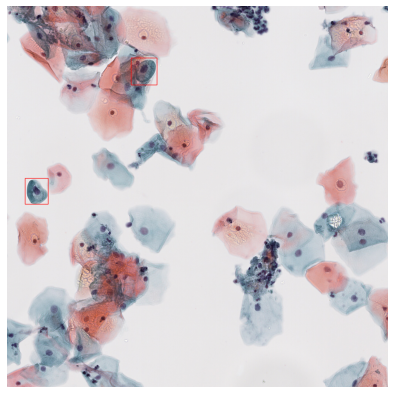

In [75]:
img_path = path[IMAGE_NUM]
abs_path = '/home/Dataset/scl/'

train_image = cv2.imread(abs_path + img_path)
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
boxes = get_data(img_path)['boxes']
print(boxes)
boxes[:,2] = boxes[:,0] + boxes[:,2]
boxes[:,3] = boxes[:,1] + boxes[:,3]

visualize(train_image, boxes[:,:4])